Loaded imresps with shape: (1573, 2, 15363)
Loaded stimids with shape: (1573,)
[-0.03714875 -0.00501692 -0.00800319 ...  0.00307682 -0.00919148
  0.04426321]
[-0.00868034  0.00619089  0.02763966 ... -0.03072115  0.02763361
 -0.00913117]
[-0.02815993 -0.00791824 -0.03693148 ...  0.20608851  0.03279698
  0.02295515]
[-0.02738867 -0.00785604 -0.03561613 ...  0.25958626  0.0339091
  0.02349447]
Real SRV shape: (15363,)
[0.05308033 0.05872908 0.04691138 ... 0.05495982 0.0606639  0.08965408]
Number of reliable neurons: 3678
Indices of reliable neurons: [   14    70    77 ... 15357 15358 15360]
Dimensionality of neural responses: (1573, 500)
Top 500 reliable neuron indices: [13560  6355  9560  7456  9531  9363  8882  7057  8854 11562]
Corresponding SRV scores: [0.51055987 0.51016348 0.50376488 0.47566608 0.46925138 0.45591223
 0.44602006 0.43980714 0.4376625  0.43724323]
Top 500 neural responses shape: (1573, 2, 500)
Averaged top 500 neural responses shape: (1573, 500)


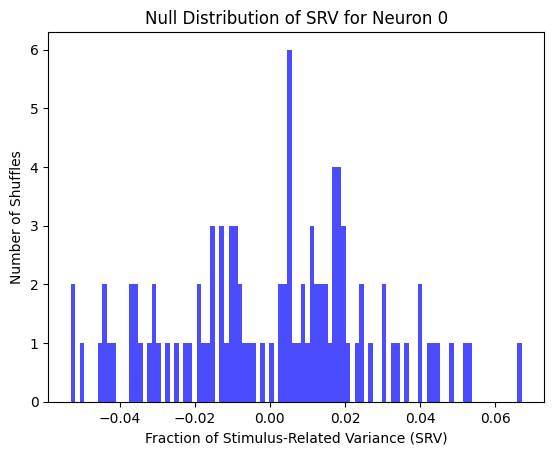

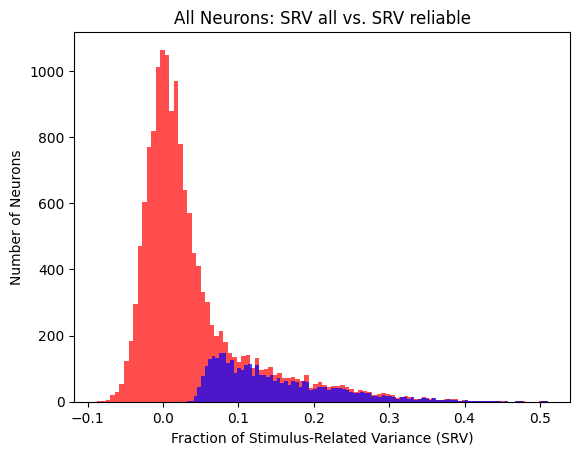

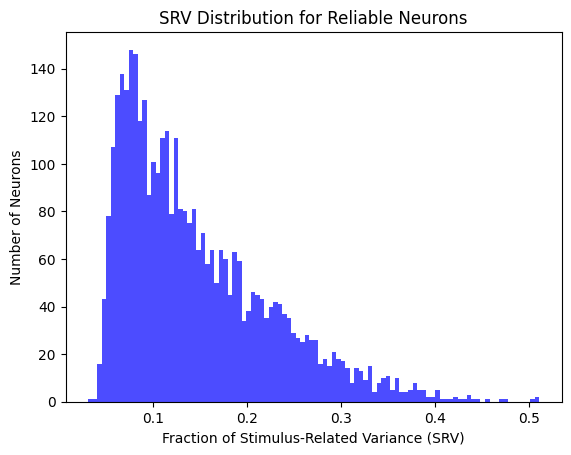

In [1]:
from cortexlib.mouse import CortexlabMouse

mouse = CortexlabMouse()

null_srv_all_neurons = mouse.compute_null_all_neurons(n_shuffles=100)
real_srv_all_neurons = mouse.compute_real_srv_all_neurons()
reliable_neuron_indices = mouse.get_reliable_neuron_indices(
            null_srv_all_neurons, real_srv_all_neurons, percentile_threshold=99)
neural_responses_mean, neural_responses, _ = mouse.get_responses_for_reliable_neurons(reliable_neuron_indices, real_srv_all_neurons, num_neurons=500)

mouse.plot_null_distribution_for_neuron(null_srv_all_neurons, neuron_index=0)
mouse.plot_real_srv_distribution(real_srv_all_neurons, reliable_neuron_indices)

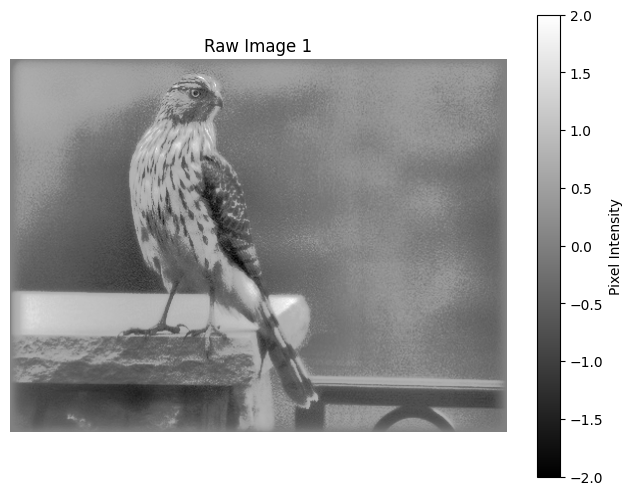

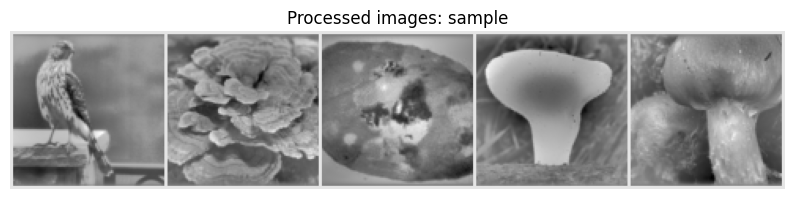

In [2]:
from cortexlib.images import CortexlabImages

images = CortexlabImages()
images.plot_raw_image(int(mouse.stimulus_ids[0]))
image_dataset = images.load_images_shown_to_mouse(mouse.stimulus_ids)
images.show_sample(image_dataset, n=5)

In [3]:
from cortexlib.simclr import PreTrainedSimCLRModel

simclr = PreTrainedSimCLRModel()
simclr_features, _ = simclr.extract_features(image_dataset)

/Users/callummessiter/workspace/msc-neuro/research-project/myenv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/callummessiter/workspace/msc-neuro/research-project/myenv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/Users/callummessiter/workspace/msc-neuro/research-project/cortexlib/cortexlib/simclr.py:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/bl

Already downloaded pretrained model: https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial17/SimCLR.ckpt


  0%|          | 0/25 [00:00<?, ?it/s]

✅ Feature extraction complete. Final feature shapes:
Final layer: torch.Size([1573, 512])
layer1: torch.Size([1573, 64, 24, 24])
layer2: torch.Size([1573, 128, 12, 12])
layer3: torch.Size([1573, 256, 6, 6])
layer4: torch.Size([1573, 512, 3, 3])


SimCLR Layer: layer1, Feats PCs: None, R^2: 0.0194 FEV: 0.1025
SimCLR Layer: layer1, Feats PCs: 10, R^2: 0.0250 FEV: 0.1187
SimCLR Layer: layer1, Feats PCs: 20, R^2: 0.0264 FEV: 0.1270
SimCLR Layer: layer1, Feats PCs: 50, R^2: 0.0181 FEV: 0.0976
SimCLR Layer: layer1, Feats PCs: 100, R^2: 0.0187 FEV: 0.1002
SimCLR Layer: layer1, Feats PCs: 200, R^2: 0.0191 FEV: 0.1015
SimCLR Layer: layer1, Feats PCs: 300, R^2: 0.0192 FEV: 0.1001
SimCLR Layer: layer1, Feats PCs: 400, R^2: 0.0193 FEV: 0.1001
SimCLR Layer: layer1, Feats PCs: 500, R^2: 0.0193 FEV: 0.1015
SimCLR Layer: layer2, Feats PCs: None, R^2: 0.0308 FEV: 0.1779
SimCLR Layer: layer2, Feats PCs: 10, R^2: 0.0279 FEV: 0.1240
SimCLR Layer: layer2, Feats PCs: 20, R^2: 0.0324 FEV: 0.1347
SimCLR Layer: layer2, Feats PCs: 50, R^2: 0.0345 FEV: 0.1512
SimCLR Layer: layer2, Feats PCs: 100, R^2: 0.0342 FEV: 0.1620
SimCLR Layer: layer2, Feats PCs: 200, R^2: 0.0336 FEV: 0.1693
SimCLR Layer: layer2, Feats PCs: 300, R^2: 0.0325 FEV: 0.1730
SimCLR Layer

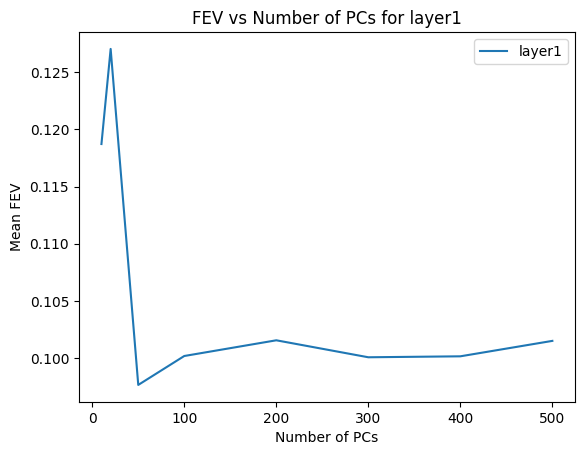

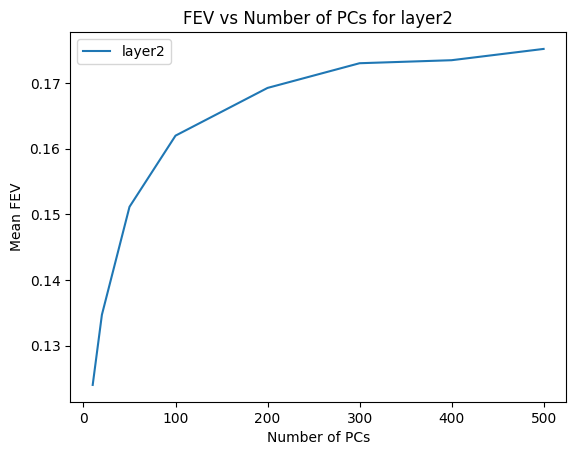

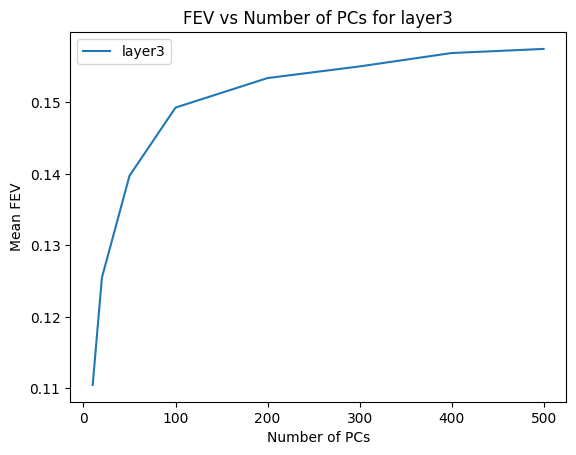

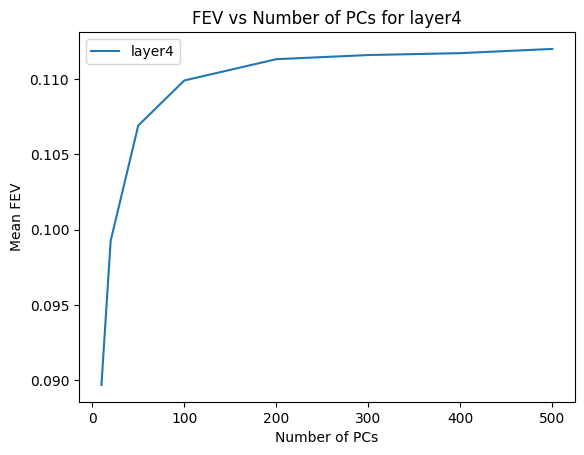

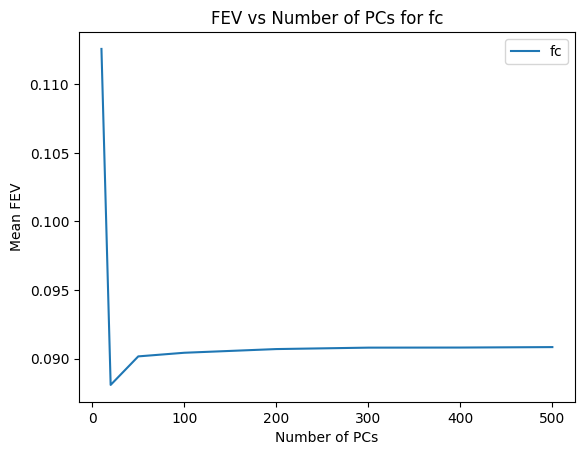

In [4]:
from cortexlib.predictor import NeuralResponsePredictor
import matplotlib.pyplot as plt
import pandas as pd

results = []

for layer, feats in simclr_features.items():
    for n_pcs in [None, 10, 20, 50, 100, 200, 300, 400, 500]:
        predictor = NeuralResponsePredictor(reduce_image_representation_to_n_pcs=n_pcs)
        r_squared = predictor.compute_r_squared(feats, neural_responses)
        fev = predictor.compute_fev(feats, neural_responses)

        results.append({
            'layer': layer,
            'n_pcs': n_pcs,
            'test_r2': r_squared['test_r2'],
            'mean_fev': fev['mean_fev']
        })
        
        print(f"SimCLR Layer: {layer}, Feats PCs: {n_pcs}, R^2: {r_squared['test_r2']:.4f} FEV: {fev['mean_fev']:.4f}")

# For each player, plot a line of FEV against number of PCs
results_df = pd.DataFrame(results)
for layer in results_df['layer'].unique():
    layer_results = results_df[results_df['layer'] == layer]
    plt.plot(layer_results['n_pcs'], layer_results['mean_fev'], label=layer)
    plt.xlabel('Number of PCs')
    plt.ylabel('Mean FEV')
    plt.title(f'FEV vs Number of PCs for {layer}')
    plt.legend()
    plt.show()